# FB Prophet - Univariate Modelling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib as mp
from datetime import datetime
import plotly.express as px

mp.rcParams['figure.figsize'] = (10,8)
mp.rcParams['axes.grid'] = True

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
ny_df = df.set_index('timeStamp') # SETTING THE INDEX

### Resampling the data Day wise ... the raw data was at hour level

- Here we will only focusing on the demand column

array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

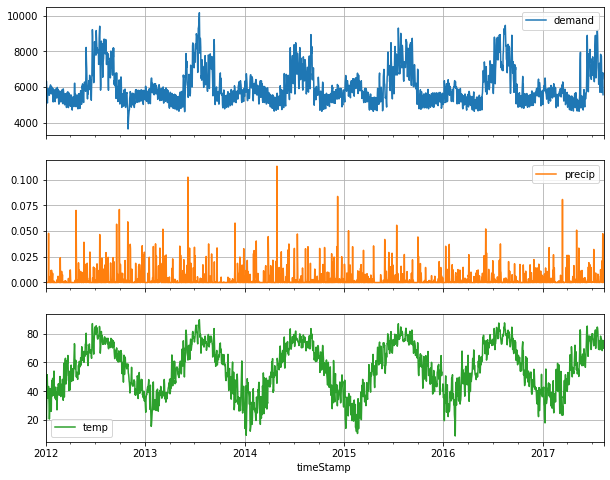

In [9]:
ny_df.resample('D').mean().plot(subplots=True)

### Mainly we will learn to predict the demand based only on the seasonality 

In [11]:
ny_df_daily = ny_df.resample('D').mean()

In [15]:
ny_df_daily

demand    precip       temp
timeStamp                                   
2012-01-01  4954.833333  0.002487  46.510000
2012-01-02  5302.954167  0.000000  40.496667
2012-01-03  6095.512500  0.000000  26.672500
2012-01-04  6336.266667  0.000000  20.585000
2012-01-05  6130.245833  0.000000  33.577500
...                 ...       ...        ...
2017-08-08  6471.626042  0.000000  71.039167
2017-08-09  6811.112167  0.047529  73.852500
2017-08-10  5582.297000  0.002033  75.217500
2017-08-11          NaN  0.000000  72.767917
2017-08-12          NaN  0.000443  69.771429

[2051 rows x 3 columns]

## Basically how the fb prophet works is that it combines the Trend , Seasonality and Holiday and residual

    y(t) = g(t) + s(t) + h(t) + residual
    
    g(t) = for the trend component it runs linear peicewise function internally
    s(t) = mainly the periodic functions that come into account for eg. monthly, yearly, hourly , minutely . By Default the
           Facebook models additive seasonalities.
    h(t) = Holidays (We can basically give some explicit dates to the model to make change in behaviour)
    
    residual = the error component ... this is always assumed to be normally distributed
           
    NOTE : our dataset doesnot have any trend. it is stationary around the mean. in the old amazon dataset there is trend +
           seasonality. so additive model wont work in this energy consumption dataset type. mainly for these types of 
           models multiplicative models comes into play

## Prophet is an open source library published by Facebook that is based on decomposable ( trend + seasonality + holidays ) models. It provides us with the ability to make time series predictions with good accuracy using simple intuitive parameters and has support for including impact of custom seasonality and holidays

In [14]:
ny_df_daily.columns

Index(['demand', 'precip', 'temp'], dtype='object')

In [16]:
from fbprophet import Prophet

ny_df_final = ny_df_daily.reset_index()[['timeStamp', 'demand']].rename({'timeStamp' : 'ds', 'demand' : 'y'}, axis='columns')
ny_df_final

ds            y
0    2012-01-01  4954.833333
1    2012-01-02  5302.954167
2    2012-01-03  6095.512500
3    2012-01-04  6336.266667
4    2012-01-05  6130.245833
...         ...          ...
2046 2017-08-08  6471.626042
2047 2017-08-09  6811.112167
2048 2017-08-10  5582.297000
2049 2017-08-11          NaN
2050 2017-08-12          NaN

[2051 rows x 2 columns]

In [24]:
train = ny_df_final[(ny_df_final['ds'] >= '2012-01-01') & (ny_df_final['ds'] <= '2017-04-30')]
test = ny_df_final[(ny_df_final['ds'] <= '2017-04-30')]

In [25]:
train.shape, test.shape

((1947, 2), (1947, 2))

### BY DEFAULT CONF INTERVAL= 80% , AND FB PROPHET WILL UNDERSTAND IF THERE IS ANY SEASONALITY BUT YOU CAN ALSO MENTION EXPLICITLY

In [27]:
m = Prophet(interval_width=0.95, yearly_seasonality=True) 

m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
m.params

{'k': array([[0.0904869]]),
 'm': array([[0.59319176]]),
 'delta': array([[-5.98524332e-08, -6.17327156e-07, -1.03577021e-01,
         -1.52222433e-07,  5.84832656e-08,  2.05510231e-07,
          8.31936121e-08, -5.22676140e-08, -2.36970495e-07,
          6.54709368e-08, -2.56606000e-02, -7.73037264e-02,
         -1.22981847e-03,  2.79551629e-07,  2.45564246e-01,
          3.63749781e-05,  5.12143950e-08, -9.50330996e-02,
         -4.66402486e-02, -1.23774007e-07,  3.68285506e-08,
          1.12213784e-07,  1.01759819e-02,  8.65253246e-03,
          1.14471246e-07]]),
 'sigma_obs': array([[0.04598117]]),
 'beta': array([[-0.03460032, -0.07054935,  0.0576081 ,  0.04706952, -0.01405823,
         -0.00500242, -0.00386301, -0.00074187,  0.00241957, -0.00755472,
          0.00405695,  0.00483124, -0.00789553, -0.00470369,  0.00701944,
         -0.00268304, -0.00127473,  0.00170726,  0.00035404, -0.0002191 ,
         -0.02824858,  0.02385163,  0.02062359,  0.00054828, -0.00494964,
         -

In [29]:
future = m.make_future_dataframe(periods=104)
future.tail() # JUST MAKING FUTURE DATES

ds
2046 2017-08-08
2047 2017-08-09
2048 2017-08-10
2049 2017-08-11
2050 2017-08-12

In [30]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2046 2017-08-08  7591.842876  6677.459590  8488.637032
2047 2017-08-09  7580.959047  6588.370153  8516.541580
2048 2017-08-10  7535.677286  6616.212460  8450.865492
2049 2017-08-11  7490.895873  6617.413683  8329.484670
2050 2017-08-12  6916.077427  5958.875984  7844.682452

<AxesSubplot:xlabel='ds'>

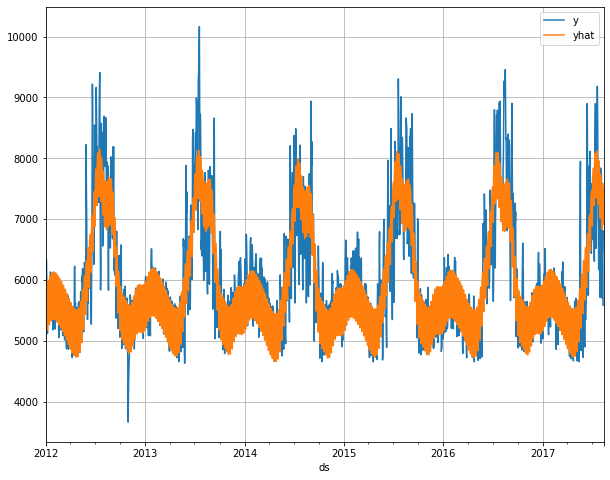

In [31]:
pd.concat([ny_df_final.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis=1).plot()

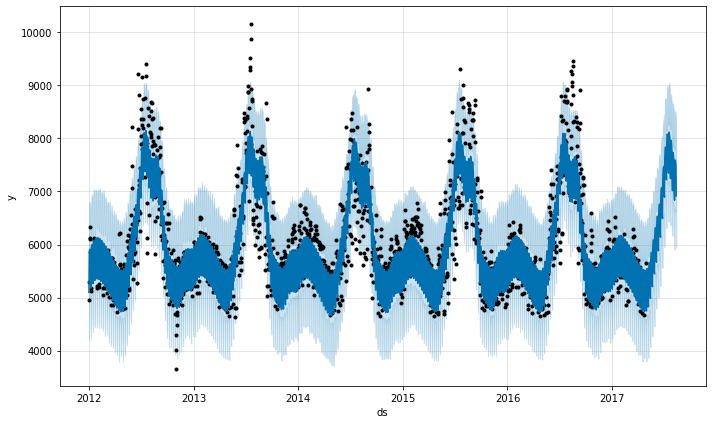

In [32]:
fig1 = m.plot(forecast)

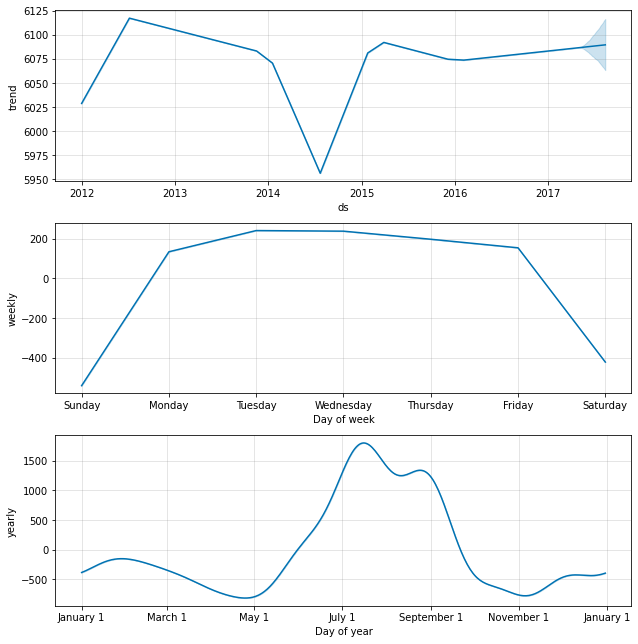

In [33]:
fig2 = m.plot_components(forecast)

### By default it will only show the 80% change points in the data

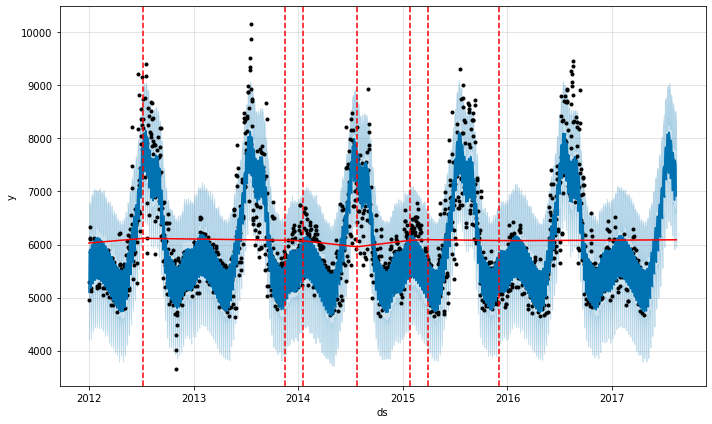

In [34]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [35]:
deltas = m.params['delta'].mean(0)
deltas

array([-5.98524332e-08, -6.17327156e-07, -1.03577021e-01, -1.52222433e-07,
        5.84832656e-08,  2.05510231e-07,  8.31936121e-08, -5.22676140e-08,
       -2.36970495e-07,  6.54709368e-08, -2.56606000e-02, -7.73037264e-02,
       -1.22981847e-03,  2.79551629e-07,  2.45564246e-01,  3.63749781e-05,
        5.12143950e-08, -9.50330996e-02, -4.66402486e-02, -1.23774007e-07,
        3.68285506e-08,  1.12213784e-07,  1.01759819e-02,  8.65253246e-03,
        1.14471246e-07])

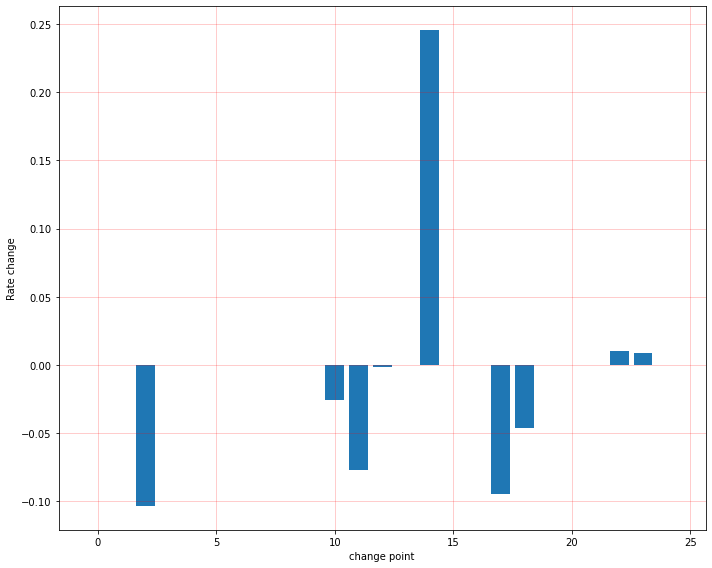

In [37]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='red', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('change point')
fig.tight_layout()

In [39]:
m.changepoints # at max 25 change points are shown

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


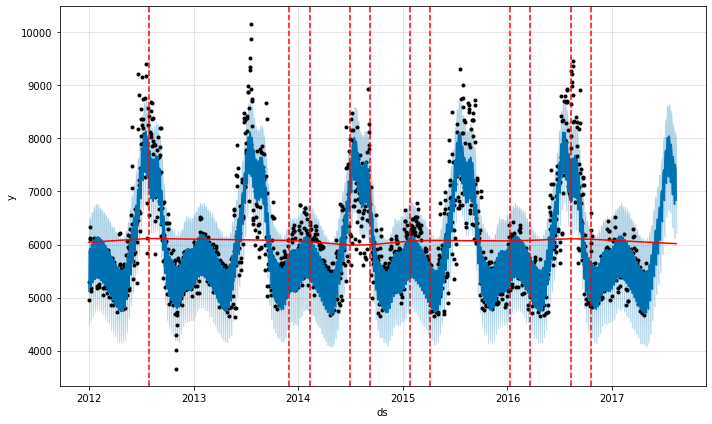

In [40]:
pro_change = Prophet(changepoint_range=0.9, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [41]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(m, forecast) # This returns a plotly figure
py.iplot(fig)

In [42]:
from fbprophet.diagnostics import cross_validation
cv_results = cross_validation(model=m, initial='731 days', horizon='365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
cv_results.head()

ds         yhat   yhat_lower   yhat_upper            y     cutoff
0 2014-05-02  5563.525540  4722.162215  6337.826043  5460.325000 2014-05-01
1 2014-05-03  4973.621663  4136.267735  5818.116063  4893.683333 2014-05-01
2 2014-05-04  4849.831474  3951.045269  5675.403568  4764.137500 2014-05-01
3 2014-05-05  5530.813885  4678.551856  6344.187974  5406.762500 2014-05-01
4 2014-05-06  5625.821994  4809.229670  6340.807039  5409.750000 2014-05-01

In [44]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p

horizon            mse        rmse         mae      mape  \
0    36 days 12:00:00  251533.449535  501.531105  405.437809  0.072880   
1    37 days 00:00:00  258330.567980  508.262302  412.884031  0.074176   
2    37 days 12:00:00  260587.325466  510.477546  416.203528  0.074746   
3    38 days 00:00:00  263443.890966  513.267855  419.332929  0.075014   
4    38 days 12:00:00  267080.896377  516.798700  424.495767  0.075838   
..                ...            ...         ...         ...       ...   
653 363 days 00:00:00  259308.715576  509.223640  447.075399  0.082531   
654 363 days 12:00:00  260793.587993  510.679536  447.981302  0.082691   
655 364 days 00:00:00  265328.210627  515.100195  451.682966  0.083560   
656 364 days 12:00:00  265197.365508  514.973170  451.215629  0.083511   
657 365 days 00:00:00  260981.631514  510.863613  448.233150  0.083393   

        mdape  coverage  
0    0.065090  0.879121  
1    0.065748  0.873626  
2    0.066774  0.873626  
3    0.067436  0.873626  
4    0.067820  0.873626  
..        ...       ...  
653  0.082341  0.983516  
654  0.082341  0.983516  
655  0.083240  0.983516  
656  0.083240  0.983516  
657  0.083573  0.983516  

[658 rows x 7 columns]